In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import os

rnd = 384
np.random.seed(rnd)

In [2]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/adult_clear.csv')
df = df[df["workclass"] != "?"]
df = df[df["occupation"] != "?"]
df = df[df["native-country"] != "?"]
df.replace(['Divorced', 'Married-AF-spouse',
            'Married-civ-spouse', 'Married-spouse-absent',
            'Never-married', 'Separated', 'Widowed'],
           ['notmarried', 'married', 'married', 'married',
            'notmarried', 'notmarried', 'notmarried'], inplace=True)
df['education'].replace(['Preschool', '10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th'], 'dropout',
                        inplace=True)
df['education'].replace(['HS-Grad', 'HS-grad'], 'HighGrad', inplace=True)
df['education'].replace(['Some-college', 'Assoc-acdm', 'Assoc-voc'], 'CommunityCollege', inplace=True)
df = df[df.race == 'White']
# excludes 10 observations
df = df[df['workclass'] != 'Never-worked']
# excludes 14 observations
df = df[df['occupation'] != 'Armed-Forces']
# excludes 21 observations
df = df[df['workclass'] != 'Without-pay']
df.drop(['fnlwgt', 'educational-num', 'relationship', 'race', 'capital-gain', 'capital-loss'],
            axis=1, inplace=True)
df['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Gov', inplace=True)
df['workclass'].replace(['Private', 'Self-emp-not-inc', 'Self-emp-inc'], 'Private', inplace=True)
df['occupation'].replace(
    ['Craft-repair', 'Machine-op-inspct', 'Handlers-cleaners', 'Transport-moving', 'Adm-clerical',
     'Farming-fishing'], 'BlueCollar', inplace=True)
df['occupation'].replace(['Other-service', 'Protective-serv', 'Tech-support', 'Priv-house-serv'], 'Services',
                         inplace=True)
df['occupation'].replace(['Exec-managerial'], 'ExecManagerial', inplace=True)
df['occupation'].replace(['Prof-specialty'], 'ProfSpecialty', inplace=True)
df['education'].replace(['Prof-school'], 'ProfSchool', inplace=True)
df['native-country'].replace(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', \
                              'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',\
                              'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland',\
                              'Italy', 'Jamaica', 'Japan', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)',\
                              'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South',\
                              'Taiwan','Thailand', 'Trinadad&Tobago', 'Vietnam','Yugoslavia'], 'Non_US', inplace=True)
df.rename(columns={'hours-per-week': 'hoursPerWeek'}, inplace=True)
df.rename(columns={'marital-status': 'marital_status'}, inplace=True)
df.rename(columns={'native-country': 'native_country'}, inplace=True)
columns_titles = ["age","hoursPerWeek","education","marital_status","occupation","gender","native_country","income"]
df=df.reindex(columns=columns_titles)
X = df.copy()
enc = OrdinalEncoder()
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,2:] = enc.fit_transform(X.values[:,2:]).astype(int)
X.iloc[:,:2] = std.fit_transform(X.values[:,:2])
X.drop(['income'], axis=1, inplace=True)
y = df["income"].apply(lambda x: ">50K" in x).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [3]:
X_train

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country
3646,0.506849,-0.510204,3,1,4,0,1
22522,-0.561644,-0.204082,1,0,2,0,1
40214,0.479452,-0.204082,1,1,0,0,1
30368,-0.616438,-0.204082,1,1,0,1,1
28758,-0.808219,0.000000,1,0,0,1,1
...,...,...,...,...,...,...,...
23011,-0.397260,-0.204082,3,1,0,1,1
6421,-0.616438,0.000000,5,1,2,1,1
18605,0.260274,0.000000,4,0,1,1,1
28637,-0.534247,0.244898,0,1,3,1,1


In [4]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train.values, y_train.values)
# train model
bst = xgb.train({'objective':'binary:logistic'}, dtrain, 20)
bst.save_model('black_box.bst')

[11:13:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [92]:
def predict(x):
    if len(x.shape)==1:
        d = xgb.DMatrix(x.reshape(1,-1))
    else:
        d = xgb.DMatrix(x)
    return bst.predict(d)

In [6]:
dtest = xgb.DMatrix(X_test.values)
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

train acc: 0.8285043573335048
test acc: 0.8189067524115755


In [7]:
X_train = np.hstack((X_train.values,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test.values,y_test_pred.reshape(-1,1)))

In [8]:
latent_dim = 2 
batch_size = 4096
sigma = 3
max_epochs = 2000
early_stopping = 3
learning_rate = 1e-3

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')
    
def loss_function(X, Z, sigma=1):
    Sx = compute_similarity(X, sigma)
    Sz = compute_similarity(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [ ]:
def compute_similarity(X,sigma=5):
    M = torch.exp((-torch.cdist(X,X)**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/adult_{latent_dim}.pt')

In [9]:
model.load_state_dict(torch.load(f'./models/adult_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

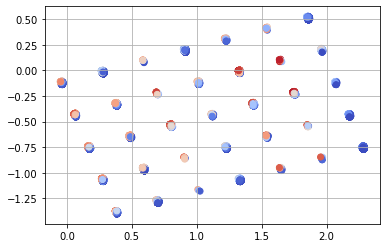

In [10]:
plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
plt.grid()

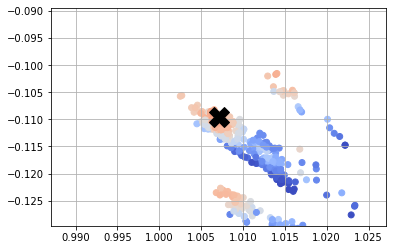

In [11]:
idx = 0
plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
plt.plot(Z_test[idx,0],Z_test[idx,1],'kX',markersize=20)
offset = 0.02
plt.axis([Z_test[idx,0]-offset,Z_test[idx,0]+offset,Z_test[idx,1]-offset,Z_test[idx,1]+offset])
plt.grid()

In [12]:
predict(X_test[idx:idx+1,:-1])

array([0.67922497], dtype=float32)

In [13]:
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

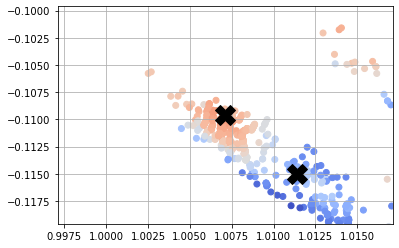

In [14]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = -1
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'kX', markersize=20)
offset = 0.01
plt.axis([Z_test[idx,0]-offset,Z_test[idx,0]+offset,Z_test[idx,1]-offset,Z_test[idx,1]+offset])
plt.grid()

In [15]:
from scipy.spatial.distance import cdist
neigh = np.argsort(cdist(Z_train,Z_test[idx:idx+1]).ravel())[:10]
predict(X_train[neigh,:-1])

array([0.67922497, 0.67922497, 0.67922497, 0.6879743 , 0.63992363,
       0.63992363, 0.69939625, 0.67922497, 0.69939625, 0.69939625],
      dtype=float32)

In [16]:
from scipy.spatial.distance import cdist
neigh = np.argsort(cdist(Z_train,Z_test[idx:idx+1]+m*y_contrib).ravel())[:10]
predict(X_train[neigh,:-1])

array([0.1896082 , 0.20896077, 0.3477488 , 0.33565715, 0.33565715,
       0.2550969 , 0.1896082 , 0.35430622, 0.35430622, 0.3107313 ],
      dtype=float32)

In [17]:
pd.DataFrame(np.vstack((X_test[idx],X_train[neigh])),columns=df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,0.095890,0.000000,3.0,0.0,1.0,1.0,1.0,0.679225
1,-0.178082,-0.510204,3.0,0.0,1.0,1.0,1.0,0.189608
2,-0.068493,-0.408163,3.0,0.0,1.0,1.0,1.0,0.208961
3,-0.041096,0.204082,3.0,1.0,1.0,1.0,1.0,0.347749
4,0.041096,0.204082,3.0,1.0,1.0,1.0,1.0,0.335657
5,0.041096,0.204082,3.0,1.0,1.0,1.0,1.0,0.335657
6,0.123288,0.408163,3.0,1.0,1.0,1.0,1.0,0.255097
7,-0.232877,-0.510204,3.0,0.0,1.0,1.0,1.0,0.189608
8,0.150685,0.204082,3.0,1.0,1.0,1.0,1.0,0.354306
9,0.150685,0.204082,3.0,1.0,1.0,1.0,1.0,0.354306


In [69]:
model.fc1.weight.shape

torch.Size([2, 8])

In [95]:
v = np.array([Z_test[idx,0]+m*y_contrib[0],Z_test[idx,1]+m*y_contrib[1]])
v

array([ 1.01137692, -0.11502723])

In [96]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
w

array([[ 0.00096203, -0.00487722,  0.3162447 ,  0.00448946,  0.1055403 ,
        -0.000927  , -0.00766923, -0.00427491],
       [ 0.002935  ,  0.00487809,  0.10541356, -0.0045248 , -0.31597713,
         0.0130301 , -0.00680402,  0.0054218 ]], dtype=float32)

In [97]:
q = X_test[0,:].copy()
c_l = [v[l] - np.sum(q*w[l,:]) - b[l] for l in range(2)]
c_l

[0.004274898189084553, -0.005421782211050941]

In [98]:
l = 0
k = 0
M = []
for l in range(2):
    M.append([np.sum(w[k,:2]*w[l,:2]) for k in range(2)])
M = np.vstack(M)
M

array([[ 2.4712821e-05, -2.0967978e-05],
       [-2.0967978e-05,  3.2410026e-05]], dtype=float32)

In [99]:
lambda_k = np.linalg.solve(M,c_l)
lambda_k

array([  68.82546207, -122.75989727])

In [103]:
delta_i = [np.sum(lambda_k*w[:,i]) for i in range(2)]
delta_i

[-0.29408786569235557, -0.9345114257126175]

In [104]:
q_cf = X_test[0, :].copy()
q_cf[:2]+=delta_i
z_q_cf = model(torch.tensor(q_cf).float()).cpu().detach().numpy()
pd.DataFrame([q,q_cf])

,0,1,2,3,4,5,6,7
0,0.095890,0.000000,3.0,0.0,1.0,1.0,1.0,0.679225
1,-0.198197,-0.934511,3.0,0.0,1.0,1.0,1.0,0.679225


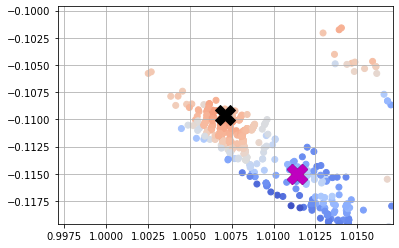

In [105]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = -1
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'kX', markersize=20)
plt.plot(z_q_cf[0], z_q_cf[1], 'mX', markersize=20)
offset = 0.01
plt.axis([Z_test[idx,0]-offset,Z_test[idx,0]+offset,Z_test[idx,1]-offset,Z_test[idx,1]+offset])
plt.grid()

In [107]:
predict(q[:-1])

array([0.67922497], dtype=float32)

In [108]:
predict(q_cf[:-1])

array([0.16659574], dtype=float32)

In [109]:
from scipy.spatial.distance import cdist
neigh = np.argsort(cdist(Z_train,z_q_cf.reshape(1,-1)).ravel())[:10]
predict(X_train[neigh,:-1])

array([0.1896082 , 0.20896077, 0.3477488 , 0.33565715, 0.33565715,
       0.2550969 , 0.1896082 , 0.35430622, 0.35430622, 0.3107313 ],
      dtype=float32)

In [110]:
pd.DataFrame(np.vstack((q,X_train[neigh])),columns=df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,0.095890,0.000000,3.0,0.0,1.0,1.0,1.0,0.679225
1,-0.178082,-0.510204,3.0,0.0,1.0,1.0,1.0,0.189608
2,-0.068493,-0.408163,3.0,0.0,1.0,1.0,1.0,0.208961
3,-0.041096,0.204082,3.0,1.0,1.0,1.0,1.0,0.347749
4,0.041096,0.204082,3.0,1.0,1.0,1.0,1.0,0.335657
5,0.041096,0.204082,3.0,1.0,1.0,1.0,1.0,0.335657
6,0.123288,0.408163,3.0,1.0,1.0,1.0,1.0,0.255097
7,-0.232877,-0.510204,3.0,0.0,1.0,1.0,1.0,0.189608
8,0.150685,0.204082,3.0,1.0,1.0,1.0,1.0,0.354306
9,0.150685,0.204082,3.0,1.0,1.0,1.0,1.0,0.354306


In [113]:
X_pred_0 = X_train[y_train_pred<=0.5]

In [124]:
X_pred_0_neigh = np.argsort(cdist(X_pred_0,X_test[0,:].reshape(1,-1)).ravel())[:10]
pd.DataFrame(np.vstack((q,X_train[y_train_pred<=0.5][X_pred_0_neigh])),columns=df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,0.095890,0.000000,3.0,0.0,1.0,1.0,1.0,0.679225
1,0.068493,-0.306122,3.0,0.0,1.0,1.0,1.0,0.443434
2,-0.013699,-0.306122,3.0,0.0,1.0,1.0,1.0,0.456739
3,-0.013699,-0.306122,3.0,0.0,1.0,1.0,1.0,0.456739
4,0.397260,-0.204082,3.0,0.0,1.0,1.0,1.0,0.460933
5,0.205479,-0.306122,3.0,0.0,1.0,1.0,1.0,0.389730
6,-0.123288,-0.306122,3.0,0.0,1.0,1.0,1.0,0.440966
7,0.369863,-0.265306,3.0,0.0,1.0,1.0,1.0,0.445882
8,0.369863,-0.306122,3.0,0.0,1.0,1.0,1.0,0.389730
9,0.397260,-0.265306,3.0,0.0,1.0,1.0,1.0,0.350050
